In [1]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys

#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import idistill.model
import idistill.data

/home/mattyshen/anaconda3/lib/python3.9/site-packages/aiohttp/helpers.py:107: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def noop(*args, **kwargs):  # type: ignore
2025-01-08 11:47:54.528012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 11:47:59.214917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mattyshen/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:34: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as

In [2]:
import torch

In [3]:
sys.path.append('/home/mattyshen/iCBM')

In [4]:
model = torch.load(f'/home/mattyshen/iCBM/CUB/best_models/Joint0.01SigmoidModel__Seed2/outputs/best_model_2.pth', weights_only=False)

In [5]:
class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
            
def fit_model(model, X_train, y_train, feature_names, no_interaction, r):
    # fit the model
    fit_parameters = inspect.signature(model.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        model.fit(X_train, y_train, feature_names=feature_names)
    elif "no_interaction" in fit_parameters and len(no_interaction) > 0:
        #ft_distill models
        model.fit(X_train, y_train, no_interaction=no_interaction)
    elif type(model) == imodels.importance.rf_plus.RandomForestPlusRegressor:
        model.fit(X_train, y_train.to_numpy())
    else:
        model.fit(X_train, y_train)

    return r, model


def evaluate_model(model, comp, task, X_train, X_val, y_train, y_val, r):
    """Evaluate model performance on each split"""
    if task == 'regression':
        metrics = {
            "r2_score": r2_score,
        }
    else:
        metrics = {
            "accuracy": accuracy_score,
        }
    for split_name, (X_, y_) in zip(
        ["train", "val"], [(X_train, y_train), (X_val, y_val)]
    ):
        y_pred_ = model.predict(X_)
        for metric_name, metric_fn in metrics.items():
            r[f"{metric_name}_{split_name}_{comp}"] = metric_fn(y_, y_pred_)

    return r

In [20]:
def load_csvs(path):

    X_train = pd.read_csv(f'{path}/X_trainval.csv', index_col=0)
    X_train_hat = pd.read_csv(f'{path}/X_trainval_hat.csv', index_col=0)
    X_test = pd.read_csv(f'{path}/X_test.csv', index_col=0)
    X_test_hat = pd.read_csv(f'{path}/X_test_hat.csv', index_col=0)
    y_train = pd.read_csv(f'{path}/y_trainval.csv', index_col=0)
    y_train_hat = pd.read_csv(f'{path}/y_trainval_hat.csv', index_col=0)
    y_test = pd.read_csv(f'{path}/y_test.csv', index_col=0)
    y_test_hat = pd.read_csv(f'{path}/y_test_hat.csv', index_col=0)

    return X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns

/home/mattyshen/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/mattyshen/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [45]:
def find_optimal_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def process_X(X_train, X_train_hat, X_test, X_test_hat, prepro, thresh=0):
    if prepro == "probs":
        return X_train_hat, X_test_hat
    elif prepro == 'binary' and thresh > 0:
        return (X_train_hat > thresh).astype(int), (X_test_hat > thresh).astype(int), 
    elif prepro == 'cluster':
        return 0
    else:
        optimal_thresholds = []
        for class_idx in range(X_train_hat.shape[1]):
            y_true_class = X_train.iloc[:, class_idx]
            y_probs_class = X_train_hat.iloc[:, class_idx]
            optimal_thresholds.append(find_optimal_threshold(y_true_class, y_probs_class))
        optimal_thresholds = np.array(optimal_thresholds)
        
        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), 

In [ ]:
def find_thresh(linkage_matrix, min_clusters=10, max_clusters=15, step=0.1):
    threshold = 1.5
    while threshold < 10:
        clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
        num_clusters = len(set(clusters))
        if min_clusters <= num_clusters <= max_clusters:
            return threshold, num_clusters
        threshold += step
    return None, 0

def cluster_concepts(X):
    distance_matrix = 1 - X_train_hat.corr().abs()
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    threshold = find_thresh(linkage_matrix, min_clusters=10, max_clusters=15, step=0.1):
        
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    feature_groups = {}
    for i, cluster_id in enumerate(clusters):
        feature_groups.setdefault(cluster_id, []).append(correlation_matrix.columns[i])
    
    return feature_groups

In [184]:
X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat = load_csvs(f'/home/mattyshen/DistillationEdit/data/cub_tabular/seed0_Joint0.01SigmoidModel__Seed1')

In [21]:
correlation_matrix = X_train_hat.corr()

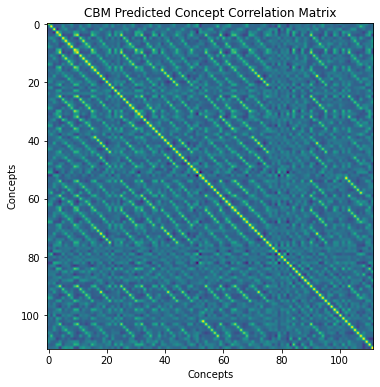

In [174]:
plt.figure(figsize=(6, 6))
plt.imshow(correlation_matrix)
plt.xlabel('Concepts')
plt.ylabel('Concepts')
plt.title('CBM Predicted Concept Correlation Matrix')
plt.savefig(f'../figures/corr.png')

/tmp/ipykernel_62041/2334550497.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


Feature Groups:
Group 5: ['c1', 'c9', 'c15', 'c21', 'c30', 'c36', 'c44', 'c49', 'c59', 'c63', 'c69', 'c75', 'c95', 'c108']
Group 7: ['c2', 'c3', 'c4', 'c23', 'c24', 'c25', 'c32', 'c38', 'c39', 'c51', 'c52', 'c53', 'c54', 'c77', 'c78', 'c79', 'c80', 'c81', 'c82', 'c83', 'c84', 'c85', 'c86', 'c87', 'c88', 'c89', 'c90', 'c97', 'c98', 'c99', 'c100', 'c101', 'c102', 'c103', 'c109', 'c110', 'c111', 'c112']
Group 2: ['c5', 'c11', 'c17', 'c26', 'c33', 'c40', 'c55', 'c60', 'c65', 'c71', 'c91', 'c104']
Group 6: ['c6', 'c12', 'c18', 'c27', 'c34', 'c41', 'c46', 'c56', 'c61', 'c66', 'c72', 'c92', 'c105']
Group 3: ['c7', 'c13', 'c19', 'c28', 'c42', 'c47', 'c57', 'c67', 'c73', 'c93', 'c106']
Group 4: ['c8', 'c14', 'c20', 'c29', 'c35', 'c43', 'c48', 'c58', 'c62', 'c68', 'c74', 'c94', 'c107']
Group 1: ['c10', 'c16', 'c22', 'c31', 'c37', 'c45', 'c50', 'c64', 'c70', 'c76', 'c96']


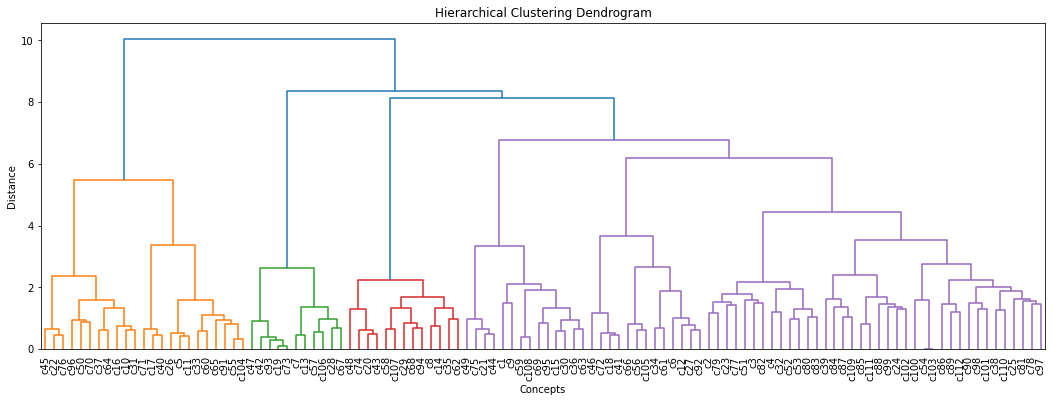

In [167]:
distance_matrix = 1 - correlation_matrix.abs()

# Perform hierarchical clustering using the distance matrix
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot the dendrogram to visualize the clustering
plt.figure(figsize=(18, 6))
dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Concepts")
plt.ylabel("Distance")
plt.savefig(f'../figures/dendrogram.png')

# Define a distance threshold to form clusters
threshold = 5  # Adjust based on your dataset and dendrogram
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Group features into clusters
feature_groups = {}
for i, cluster_id in enumerate(clusters):
    feature_groups.setdefault(cluster_id, []).append(distance_matrix.columns[i])

# Print the feature groups
print("Feature Groups:")
for cluster_id, features in feature_groups.items():
    print(f"Group {cluster_id}: {features}")

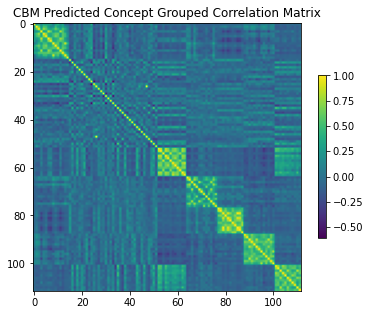

In [191]:
flat_list = [
    x
    for xs in [feature_groups[k] for k in feature_groups.keys()]
    for x in xs
]
plt.figure(figsize=(6, 6))
plt.imshow(X_train_hat[flat_list].corr())
plt.title('CBM Predicted Concept Grouped Correlation Matrix')
plt.colorbar(shrink=0.5)
plt.savefig(f'../figures/corr_grouped.png')


Text(0.5, 1.0, 'GPT4 Cluster Size Histogram')

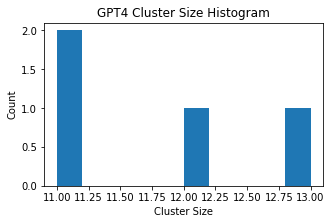

In [211]:
f_gs = {1:[1,3,5,7,8,11,12,15,16,19,20,21,22,24,26,27,40,41,42,43,46,49,50,53,55,56,60,62,64,65,66,69,70,71,72,77,78,79,80,83,84,85,87,88,90,91,92,93,94,95,102,106,107,108,110],
                2:[4,6,10,13,14,17,18,23,25,29,54,73,76,86,89,97,98,104,105,111],
                3:[2,9,28,30,32,33,34,35,36,37,38,39,47,48,51,52,81,96,99],
                4:[31,44,45,57,58,59,61,63,67,68,74,75,82,100,101,103,109,112]
        }
plt.figure(figsize=(5, 3))
plt.hist([len(feature_groups[k]) for k in f_gs.keys()])
plt.xlabel('Cluster Size')
plt.ylabel('Count')
plt.title('GPT4 Cluster Size Histogram')
#plt.savefig(f'../figures/gpt4_size_hist.png')

In [216]:
f_gs.keys()

dict_keys([1, 2, 3, 4])

In [217]:
[len(feature_groups[k]) for k in f_gs.keys()]

[11, 12, 11, 13]

In [47]:

from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, f1_score, precision_recall_curve

In [84]:
shuffled_indices = np.random.permutation(X_train_hat.index)
split_indices = np.array_split(shuffled_indices, len(feature_groups.keys()))

In [90]:
for key, split in zip(feature_groups.keys(), split_indices):
    curr_cte = [int(s[1:]) - 1 for s in feature_groups[key]]
    print(curr_cte)
    X_train_hat.iloc[split, curr_cte] = X_train.iloc[split, curr_cte]

[0, 8, 14, 20, 29, 35, 43, 48, 58, 62, 68, 74, 94, 107]
[1, 2, 3, 22, 23, 24, 31, 37, 38, 50, 51, 52, 53, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 96, 97, 98, 99, 100, 101, 102, 108, 109, 110, 111]
[4, 10, 16, 25, 32, 39, 54, 59, 64, 70, 90, 103]
[5, 11, 17, 26, 33, 40, 45, 55, 60, 65, 71, 91, 104]
[6, 12, 18, 27, 41, 46, 56, 66, 72, 92, 105]
[7, 13, 19, 28, 34, 42, 47, 57, 61, 67, 73, 93, 106]
[9, 15, 21, 30, 36, 44, 49, 63, 69, 75, 95]


In [54]:
thresh = np.zeros(112)

thresh[[int(s[1:]) - 1 for s in feature_groups[8]]] = find_optimal_threshold(X_train[feature_groups[8]].values.reshape(-1, ), X_train_hat[feature_groups[8]].values.reshape(-1, ))

In [55]:
thresh

array([0.7367663, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.7367663, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.7367663, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.7367663,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.7367663,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.7367663, 0.       ,
       0.       , 0.       , 0.7367663, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.7367663, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

In [43]:
X_train_hat[feature_groups[8]].values.reshape(-1, )

array([2.8976910e-05, 1.7885547e-04, 1.4099234e-04, ..., 9.9214125e-01,
       1.0970043e-02, 3.3309803e-04])

In [ ]:
top10c = X_train.mean().sort_values(ascending=False).head(10).index.to_list()
print(top10c)
result = ",".join(str(int(item[1:]) - 1) for item in top10c)
result

In [ ]:
concepts_to_edit = [0, 5, 65]

X_train_hat.iloc[:, concepts_to_edit] = X_train.iloc[:, concepts_to_edit]

In [ ]:
len(np.where(y_train_hat.idxmax(axis = 1).astype(int).to_numpy().reshape(-1, ) == y_train.values.reshape(-1, ))[0])/5984

In [ ]:
y_train_hat.idxmax(axis = 1).to_numpy().astype(int)==y_train.values.reshape(-1, )

In [ ]:
y_train_hat.idxmax(axis = 1).astype(int).to_numpy().reshape(-1, ) == y_train.values.reshape(-1, )

In [ ]:
accuracy_score(y_test_hat.idxmax(axis=1).astype(int), y_test)

In [ ]:
np.mean(np.argmax(y_train_hat.values, axis = 1) == y_train.to_numpy().reshape(-1, ))

In [ ]:
np.arange(0, 10).reshape(2, 5)

In [ ]:
np.argmax(np.arange(0, 10).reshape(2, 5), axis = 1)

In [ ]:
y

In [ ]:
model

In [ ]:
X.todense()

In [ ]:
type(pd.DataFrame(X.values, columns=X.columns, index=X.index))

In [ ]:
type(distiller)

In [ ]:
type(distiller) == imodels.importance.rf_plus.RandomForestPlusRegressor

In [ ]:
params_coupled_dict = {( 
  'dataset_name', 
  'model_name',
  'featurizer_name',
  'featurizer_frac',
  'depth',
  'bit',
  'max_depth',
  'max_rules',
  'max_trees',
  'pre_interaction',
  'pre_max_features',
  'post_interaction',
  'post_max_features'
 ):
 [(dn,
   mn,
   fn,
   ff,
   d,
   b,
   md, 
   mr, 
   mt,
   prei,
   premf,
   posti,
   postmf
  )
 for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
 for mn in ["random_forest", "rf_plus", "xgboost", "resnet", "ft_transformer"]
 for fn in ["no_featurizer", "featurizer"]
 for ff in [0.3, 0.7]
 for d in [2, 3]
 for b in [0, 1]
 for md in [4, 5]
 for mr in [1]
 for mt in [1]
 for prei in ["l0l2"]
 for premf in [0]
 for posti in ["l0l2"]
 for postmf in [0]
 ] + 
 [(dn,
   mn,
   fn,
   ff,
   d,
   b,
   md, 
   mr, 
   mt,
   prei,
   premf,
   posti,
   postmf
  )
 for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
 for mn in ["figs"]
 for fn in ["no_featurizer", "featurizer"]
 for ff in [0.3, 0.7]
 for d in [2, 3]
 for b in [0, 1]
 for md in [1]
 for mr in [50, 60]
 for mt in [30]
 for prei in ["l0l2"]
 for premf in [0]
 for posti in ["l0l2"]
 for postmf in [0]
 ] + 
 [(dn,
   mn,
   fn,
   ff,
   d,
   b,
   md, 
   mr, 
   mt,
   prei,
   premf,
   posti,
   postmf
  )
 for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
 for mn in ["ft_distill"]
 for fn in ["featurizer"]
 for ff in [0.3, 0.7]
 for d in [2, 3]
 for b in [0, 1]
 for md in [1]
 for mr in [1]
 for mt in [1]
 for prei in ["l1l2", "l0l2"]
 for premf in [0.5]
 for posti in ["l0l2"]
 for postmf in [25, 30]
 ]
}

In [ ]:
params_coupled_dict = {}
#RF, RF+ params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'max_depth', 
                             'max_features'):
                            [(dn, mn, md, mf) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['random_forest', 'rf_plus']
                             for md in [4, 5, 6]
                             for mf in [0.5, 0.75, 1]
                            ]})
#FIGS params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'max_rules', 
                             'max_trees',
                             'max_features'):
                            [(dn, mn, mr, mt, mf) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['figs']
                             for mr in [60]
                             for mt in [20, 30]
                             for mf in [0.5, 0.75, 1]
                            ]})
#XGB params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'max_depth'):
                            [(dn, mn, md) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['xgboost']
                             for md in [4, 5, 6]
                            ]})
#FT, ResNet params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'n_epochs'):
                            [(dn, mn, ne) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['ft_transformer', 'resnet']
                             for ne in [100, 200]
                            ]})

In [ ]:
params_coupled_dict.keys()

In [ ]:
5*sum([len(params_coupled_dict[k]) for k in params_coupled_dict.keys()])

In [ ]:
t.update({('to', 'ho'): [(9, 10), (51, 61)]})

In [ ]:
t

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# Generating a sample dataset
n_samples = 100
n_features = 5

# Sample DataFrame with n_samples rows and n_features columns
X = pd.DataFrame(np.random.randn(n_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
y = pd.Series(np.random.randn(n_samples))

# Initializing KFold
kf = KFold(n_splits=5)

# Iterating over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # X_in, y_in for training data in current fold
    X_in, y_in = X_train, y_train
    
    # X_out, y_out for test data in current fold
    X_out, y_out = X_test, y_test
    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Generate some sample data
np.random.seed(42)
data = np.concatenate([np.random.normal(loc=-2, scale=0.5, size=300),
                       np.random.normal(loc=0, scale=0.3, size=500),
                       np.random.normal(loc=2, scale=0.7, size=400)])

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=3)
gmm.fit(data.reshape(-1, 1))

# Extract the means and variances of the fitted Gaussians
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()
std_devs = np.sqrt(variances)

# Sort the means for determining intersections
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_variances = variances[sorted_indices]


# Determine the intersection points using the provided formula
intersections = []
for i in range(len(sorted_means) - 1):
    mu1, var1 = sorted_means[i], sorted_variances[i]
    mu2, var2 = sorted_means[i + 1], sorted_variances[i + 1]
    
    term1 = mu1*var2 - mu2*var1
    term2 = np.sqrt(var1*var2) * np.sqrt((mu1-mu2)**2 + (var2-var1)*np.log(var2/var1))
    term3 = var2-var1
    #intersections.append((((term1+term2)/term3), ((term1-term2)/term3)))
    intersections.append(((term1+term2)/term3))


# Plot the histogram and the fitted Gaussians
x = np.linspace(min(data), max(data), 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

plt.hist(data, bins=30, density=True, alpha=0.5, color='gray')
plt.plot(x, pdf, label='GMM fit', color='black')

# Plot the individual Gaussians
for i in range(len(means)):
    plt.plot(x, (1/np.sqrt(2 * np.pi * variances[sorted_indices][i])) * 
             np.exp(-(x - sorted_means[i])**2 / (2 * variances[sorted_indices][i])),
             label=f'Gaussian {i+1}', linestyle='--')

# Plot the intersection points
for intersection in intersections:
    plt.axvline(intersection, color='red', linestyle=':', label=f'Intersection at {intersection:.2f}')

plt.legend()
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model Fit and Intersections')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Load California Housing dataset
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)

# Function to fit GMM and find intersections
def fit_gmm_and_find_intersections(data, n_components=3):
    # Fit a Gaussian Mixture Model
    def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
        return -estimator.bic(X)


    param_grid = {
        "n_components": range(0, 3),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )
    grid_search.fit(data.reshape(-1, 1))
    
    # Extract the means and variances of the fitted Gaussians
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    std_devs = np.sqrt(variances)
    
    # Sort the means for determining intersections
    sorted_indices = np.argsort(means)
    sorted_means = means[sorted_indices]
    sorted_variances = variances[sorted_indices]
    
    # Determine the intersection points using the provided formula
    intersections = []
    for i in range(len(sorted_means) - 1):
        mu1, var1 = sorted_means[i], sorted_variances[i]
        mu2, var2 = sorted_means[i + 1], sorted_variances[i + 1]
        
        term1 = mu1*var2 - mu2*var1
        term2 = np.sqrt(var1*var2) * np.sqrt((mu1-mu2)**2 + (var2-var1)*np.log(var2/var1))
        term3 = var2-var1
        intersections.append(((term1 + term2) / term3))
    
    return gmm, sorted_means, sorted_variances, intersections

# Plotting function
def plot_feature(data, feature_name, n_components=3):
    feature_data = data[feature_name].values
    gmm, sorted_means, sorted_variances, intersections = fit_gmm_and_find_intersections(feature_data, n_components)
    
    x = np.linspace(min(feature_data), max(feature_data), 1000)
    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    
    plt.hist(feature_data, bins=30, density=True, alpha=0.5, color='gray')
    plt.plot(x, pdf, label='GMM fit', color='black')
    
    for i in range(len(sorted_means)):
        plt.plot(x, (1 / np.sqrt(2 * np.pi * sorted_variances[i])) * 
                 np.exp(-(x - sorted_means[i])**2 / (2 * sorted_variances[i])),
                 label=f'Gaussian {i+1}', linestyle='--')
    
    for intersection in intersections:
        plt.axvline(intersection, color='red', linestyle=':', label=f'Intersection at {intersection:.2f}')
    
    plt.legend()
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.title(f'Gaussian Mixture Model Fit and Intersections for {feature_name}')
    plt.show()

# Plot for each feature in the dataset
for feature in data.columns:
    plot_feature(data, feature)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Load California Housing dataset
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)

# Function to fit GMM and find intersections
def fit_gmm_and_find_intersections(data, n_components=3):
    # Fit a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data.reshape(-1, 1))
    
    # Extract the means and variances of the fitted Gaussians
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    std_devs = np.sqrt(variances)
    
    # Sort the means for determining intersections
    sorted_indices = np.argsort(means)
    sorted_means = means[sorted_indices]
    sorted_variances = variances[sorted_indices]
    
    # Determine the intersection points using the provided formula
    intersections = []
    for i in range(len(sorted_means) - 1):
        mu1, var1 = sorted_means[i], sorted_variances[i]
        mu2, var2 = sorted_means[i + 1], sorted_variances[i + 1]
        
        term1 = mu1*var2 - mu2*var1
        term2 = np.sqrt(var1*var2) * np.sqrt((mu1 - mu2)**2 + (var2 - var1) * np.log(var2 / var1))
        term3 = var2 - var1
        intersections.append(((term1 + term2) / term3))
    
    return gmm, sorted_means, sorted_variances, intersections

# Function to find the optimal number of components using GridSearchCV
def find_optimal_components(data):
    param_grid = {'n_components': [1, 2, 3]}
    gmm = GaussianMixture()
    grid_search = GridSearchCV(gmm, param_grid, cv=5)
    grid_search.fit(data.reshape(-1, 1))
    return grid_search.best_params_['n_components']

# Plotting function
def plot_feature(data, feature_name):
    feature_data = data[feature_name].values
    optimal_components = find_optimal_components(feature_data)
    print(f'{feature_name}: {optimal_components}')
    gmm, sorted_means, sorted_variances, intersections = fit_gmm_and_find_intersections(feature_data, optimal_components)
    
    x = np.linspace(min(feature_data), max(feature_data), 1000)
    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    
    plt.hist(feature_data, bins=30, density=True, alpha=0.5, color='gray')
    plt.plot(x, pdf, label='GMM fit', color='black')
    
    for i in range(len(sorted_means)):
        plt.plot(x, (1 / np.sqrt(2 * np.pi * sorted_variances[i])) * 
                 np.exp(-(x - sorted_means[i])**2 / (2 * sorted_variances[i])),
                 label=f'Gaussian {i+1}', linestyle='--')
    
    for intersection in intersections:
        plt.axvline(intersection, color='red', linestyle=':', label=f'Intersection at {intersection:.2f}')
    
    plt.legend()
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.title(f'Gaussian Mixture Model Fit and Intersections for {feature_name}')
    plt.show()

# Plot for each feature in the dataset
for feature in data.columns:
    plot_feature(data, feature)
